In [2]:
from __future__ import print_function
import os
import pickle

from zipfile import ZipFile
import xml.sax, xml.sax.handler

import utm
import pyproj as proj

from netCDF4 import Dataset

import boto3
import botocore
import xarray as xr
era5_bucket = 'era5-pds'
client = boto3.client('s3', config=botocore.client.Config(signature_version=botocore.UNSIGNED))

here = os.path.dirname(os.path.abspath('/media/synology2/WANDS/ERA5/'))

import numpy as np
import time
import datetime

from sklearn import svm, datasets
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

import scipy.io
import scipy.integrate
from astropy.convolution import convolve, Box1DKernel
from spacepy import pycdf

from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib import rc
from matplotlib.colors import LogNorm
from matplotlib.patches import Polygon
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.path import Path as mpath
from matplotlib.collections import PatchCollection
import matplotlib.colors as mcolors
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.basemap import Basemap

from shapely.geometry import Point as shpoint
from shapely.geometry import Polygon as shpoly
from shapely.geometry import MultiPolygon as shmulti

import pandas as pd
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
pd.options.display.max_columns = 999
pd.options.display.max_rows = 90

np.set_printoptions(threshold=np.nan)

plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
plt.rc('text', usetex=True)

###############
## COMPUTER ##
###############

laptop = False

In [5]:
# build symmetric colormap for latitude

colors1 = plt.cm.coolwarm(np.linspace(0., 1, 128))
colors2 = plt.cm.coolwarm_r(np.linspace(0, 1, 128))

# combine them and build a new colormap
colors = np.vstack((colors1, colors2))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

In [6]:
#save the daily max wind and temp range for all land cells, data split into 64 spatial segments, big files
LANDSPLIT = 64

In [7]:
###############
## FUNCTION DEFS TO PARSE KMZ ##
###############

class PlacemarkHandler(xml.sax.handler.ContentHandler):
    def __init__(self):
        self.inName = False # handle XML parser events
        self.inPlacemark = False
        self.mapping = {} 
        self.buffer = ""
        self.name_tag = ""
        
    def startElement(self, name, attributes):
        if name == "Placemark": # on start Placemark tag
            self.inPlacemark = True
            self.buffer = "" 
        if self.inPlacemark:
            if name == "name": # on start title tag
                self.inName = True # save name text to follow
            
    def characters(self, data):
        if self.inPlacemark: # on text within tag
            self.buffer += data # save text if in title
            
    def endElement(self, name):
        self.buffer = self.buffer.strip('\n\t')
        
        if name == "Placemark":
            self.inPlacemark = False
            self.name_tag = "" #clear current name
        
        elif name == "name" and self.inPlacemark:
            self.inName = False # on end title tag            
            self.name_tag = self.buffer.strip()
            self.mapping[self.name_tag] = {}
        elif self.inPlacemark:
            if name in self.mapping[self.name_tag]:
                self.mapping[self.name_tag][name] += self.buffer
            else:
                self.mapping[self.name_tag][name] = self.buffer
        self.buffer = ""
        
def build_table(mapping):
    sep = ','
        
    output = 'Name' + sep + 'Coordinates\n'
    points = ''
    lines = ''
    shapes = ''
    for key in mapping:
        coord_str = mapping[key]['coordinates'] + sep
        
        if 'LookAt' in mapping[key]: #points
            points += key + sep + coord_str + "\n"
        elif 'LineString' in mapping[key]: #lines
            lines += key + sep + coord_str + "\n"
        else: #shapes
            shapes += key + sep + coord_str + "\n"
    output += points + lines + shapes
    return output

In [8]:
###############
## FUNCTION DEFS TO FIND DUNE FIELD AREA ##
###############

def polygonArea(vertups):
    X = vertups[:,0]
    Y = vertups[:,1]
    n = len(X) 
    # Initialze area 
    area = 0.0
    # Calculate value of shoelace formula 
    j = n - 1
    for i in range(0,n): 
        area += (X[j] + X[i]) * (Y[j] - Y[i]) 
        j = i   # j is previous vertex to i 
    # Return absolute value 
    return abs(area / 2.0)

In [9]:
##################
# PATH TO KMZ
##################
filenames  = []
dunefields = []
dunenames  = []

# round 1

filenames.append('/media/synology2/WANDS/DUNEPOLY/Grand_Erg_Oriental.kmz')
dunefields.append('Grand_Erg_Oriental')
dunenames.append('Grand Erg Oriental') #176394.987102

filenames.append('/media/synology2/WANDS/DUNEPOLY/White_Sands.kmz')
dunefields.append('White_Sands')
dunenames.append('White Sands') #522.279562

filenames.append('/media/synology2/WANDS/DUNEPOLY/Tengger.kmz')
dunefields.append('Tengger')
dunenames.append('Tengger') #33664.085683

filenames.append('/media/synology2/WANDS/DUNEPOLY/Takla_Makan.kmz')
dunefields.append('Takla_Makan')
dunenames.append('Takla Makan') #228535.317483

filenames.append('/media/synology2/WANDS/DUNEPOLY/Skeleton_Coast.kmz')
dunefields.append('Skeleton_Coast')
dunenames.append('Skeleton Coast') #1636

filenames.append('/media/synology2/WANDS/DUNEPOLY/Rub_Al_Khali.kmz')
dunefields.append('Rub_Al_Khali')
dunenames.append('Rub Al Khali') #59655.057415

filenames.append('/media/synology2/WANDS/DUNEPOLY/Registan.kmz')
dunefields.append('Registan')
dunenames.append('Registan') #29297.804001

filenames.append('/media/synology2/WANDS/DUNEPOLY/Great_Sand_Sea.kmz')
dunefields.append('Great_Sand_Sea')
dunenames.append('Great Sand Sea') #219575.474785

filenames.append('/media/synology2/WANDS/DUNEPOLY/Fachi_Bilma.kmz')
dunefields.append('Fachi_Bilma')
dunenames.append('Fachi Bilma') #189825.385307

filenames.append('/media/synology2/WANDS/DUNEPOLY/Algodones1.kmz')
dunefields.append('Algodones1')
dunenames.append('Algodones') #544.787004

filenames.append('/media/synology2/WANDS/DUNEPOLY/Akchar.kmz')
dunefields.append('Akchar')
dunenames.append('Akchar') #21070.79921

# round 2 

filenames.append('/media/synology2/WANDS/DUNEPOLY/Zaltan.kmz')
dunefields.append('Zaltan')
dunenames.append('Zaltan') #15575.982018

filenames.append('/media/synology2/WANDS/DUNEPOLY/Wahiba1.kmz')
dunefields.append('Wahiba1')
dunenames.append('Wahiba') #11848.110241

filenames.append('/media/synology2/WANDS/DUNEPOLY/Namib_Sand_Sea.kmz')
dunefields.append('Namib_Sand_Sea')
dunenames.append('Namib Sand Sea') #29103.496452

filenames.append('/media/synology2/WANDS/DUNEPOLY/Mourzuk.kmz')
dunefields.append('Mourzuk')
dunenames.append('Mourzuk') #58351.820003

filenames.append('/media/synology2/WANDS/DUNEPOLY/Lut.kmz')
dunefields.append('Lut')
dunenames.append('Lut') #8307.099626

filenames.append('/media/synology2/WANDS/DUNEPOLY/Kumtagh.kmz')
dunefields.append('Kumtagh')
dunenames.append('Kumtagh') #17797.276069

filenames.append('/media/synology2/WANDS/DUNEPOLY/Kubuqi.kmz')
dunefields.append('Kubuqi')
dunenames.append('Kubuqi') #8878.941064

filenames.append('/media/synology2/WANDS/DUNEPOLY/Jafurah.kmz')
dunefields.append('Jafurah')
dunenames.append('Jafurah') #269635.263025

filenames.append('/media/synology2/WANDS/DUNEPOLY/Issouanen_Tifernine.kmz')
dunefields.append('Issouanen_Tifernine')
dunenames.append('Issouanen Tifernine') #32157.148685

filenames.append('/media/synology2/WANDS/DUNEPOLY/Ijafene.kmz')
dunefields.append('Ijafene')
dunenames.append('Ijafene') #144691.244906

filenames.append('/media/synology2/WANDS/DUNEPOLY/Gran_Desierto_new.kmz')
dunefields.append('Gran_Desierto_new')
dunenames.append('Gran Desierto') #4816.647112

filenames.append('/media/synology2/WANDS/DUNEPOLY/Cunene.kmz')
dunefields.append('Cunene')
dunenames.append('Cunene') #2618.591006

filenames.append('/media/synology2/WANDS/DUNEPOLY/Badain_Jaran.kmz')
dunefields.append('Badain_Jaran')
dunenames.append('Badain Jaran') #43968.305677

filenames.append('/media/synology2/WANDS/DUNEPOLY/Awbari.kmz')
dunefields.append('Awbari')
dunenames.append('Awbari') #48825.044673

filenames.append('/media/synology2/WANDS/DUNEPOLY/Aoukar.kmz')
dunefields.append('Aoukar')
dunenames.append('Aoukar') #56069.588972

filenames.append('/media/synology2/WANDS/DUNEPOLY/Admer.kmz')
dunefields.append('Admer')
dunenames.append('Admer') #5572.870468

filenames.append('/media/synology2/WANDS/DUNEPOLY/Ad_Dahna.kmz')
dunefields.append('Ad_Dahna')
dunenames.append('Ad Dahna') #356614.145363

nicksareas = np.asarray([176394.987102, 522.279562, 33664.085683, 228535.317483, 1636, 59655.057415, 29297.804001, 219575.474785, 189825.385307, 544.787004, 21070.79921,
                        15575.982018, 11848.110241, 29103.496452, 58351.820003, 8307.099626, 17797.276069, 8878.941064, 269635.263025, 32157.148685, 144691.244906, 
                        4816.647112, 2618.591006, 43968.305677, 48825.044673, 56069.588972, 5572.870468, 356614.145363])


In [98]:
##################
# TURNS KMZ INTO PICKLE OF VERTEX TUPLES AND WHICH LOOPS ARE INTERIOR/EXTERIOR
##################

%cd /media/synology2/WANDS/DUNEPOLY/

for i in np.arange(0,np.shape(dunefields)[0]):

    #parse the kmz
    kmz = ZipFile(filenames[i], 'r')
    kml = kmz.open('doc.kml', 'r')
    parser = xml.sax.make_parser()
    handler = PlacemarkHandler()
    parser.setContentHandler(handler)
    parser.parse(kml)
    kmz.close()

    # find coordinate list in parsed kmz
    coords = handler.mapping[list(handler.mapping)[0]]["coordinates"]
    my_list = coords.split(",")

    #restructure string into a useful array
    verts = my_list[:-1]
    vertsclean = np.empty([int(np.shape(verts)[0]/2),2])
    polystart = [] #finds indices where new polys start and end
    if i==1: #just because i made the white sands kmz and it's formatted different to Nick's
        polystart.append(0)
        
    for j in np.arange(0,np.shape(verts)[0]):
        if '           ' in verts[j]:
            polystart.append(int(j/2))
        verts[j]=verts[j].replace('           ','')
        verts[j]=verts[j].replace('0 ','')
        verts[j]=verts[j].replace('0-','-')
        if j%2==0:
            vertsclean[int(j/2),0] = verts[j]
        else:
            vertsclean[int(j/2),1] = verts[j]
    vertups = np.asarray(vertsclean)
    polystart.append(-1) #close the polystart list

    Vertups = [] #list of the polys within a single dunefield, unsorted by internals externals

    for j in np.arange(0,np.shape(polystart)[0]-1):
        Vertups.append(vertups[polystart[j]:polystart[j+1],:])
        
    #exceptions due to polygon creation errors.
    if dunefields[i]=='Mourzuk':
        Vertups[711] = np.delete(Vertups[711], -4, 0)
        Vertups[854] = np.delete(Vertups[854], 507, 0)
#     if dunefields[i]=='Gran_Desierto_new':
#         Vertups = Vertups[1:]
        
    withins = [] #Vertup polygon indexed as x is within y

    #cycles through pairs of polygons in dunefield, sorts to which are within which
    for j in np.arange(0,np.shape(Vertups)[0]):
        
        Polyi = shpoly(Vertups[j])

        for k in np.arange(0,np.shape(Vertups)[0]):
            if Polyi.contains(shpoly(Vertups[k])):
                if j==k:
                    continue
                else:
                    withins.append([k,j]) #tells you which loops is within another

    #save as a pickle
    with open(dunefields[i] + '_verts.pkl', 'wb') as f:
        pickle.dump(Vertups, f)
        
    with open(dunefields[i] + '.pkl', 'wb') as f:
        pickle.dump(vertups, f)

    #save as a pickle
    with open(dunefields[i] + '_loops.pkl', 'wb') as f:
        pickle.dump(withins, f)
        
    print('dunefield %d'%i)

/media/synology2/WANDS/DUNEPOLY
dunefield 0
dunefield 1
dunefield 2
dunefield 3
dunefield 4
dunefield 5
dunefield 6
dunefield 7
dunefield 8
dunefield 9
dunefield 10
dunefield 11
dunefield 12
dunefield 13
dunefield 14
dunefield 15
dunefield 16
dunefield 17
dunefield 18
dunefield 19
dunefield 20
dunefield 21
dunefield 22
dunefield 23
dunefield 24
dunefield 25
dunefield 26
dunefield 27


In [11]:
# # helps find the buggy points in the vertups file
# for i in np.arange(0,np.shape(Vertups)[0]):
#     temp = Vertups[i]
#     for j in np.arange(0,np.shape(temp)[0]):
#         if np.all(Vertups[i][j]==[12.86728458500005,23.351972922000069]):
#             print(i,j)

In [140]:
##################
# TURNS VERTEX TUPLES INTO FIELD AREA
##################

%cd /media/synology2/WANDS/DUNEPOLY/
    
duneareas = np.empty([np.shape(dunefields)[0]])
duneperim = np.empty([np.shape(dunefields)[0]])
duneavlats = np.empty([np.shape(dunefields)[0]])
duneavlons = np.empty([np.shape(dunefields)[0]])

for i in np.arange(0,np.shape(dunefields)[0]):

    with open(dunefields[i] + '_verts.pkl', 'rb') as f:
        Vertups = pickle.load(f)
        
    with open(dunefields[i] + '_loops.pkl', 'rb') as f:
        withins = np.asarray(pickle.load(f))
    
    duneareas[i] = 0
    duneperim[i] = 0  
    
    for j in np.arange(0,np.shape(Vertups)[0]):
        
        vertups = Vertups[j]
        
        #find median UTM of the lat-lon coordinates for the vertices
        utmzone = np.empty(np.shape(vertups)[0])
        for k in np.arange(0,np.shape(vertups)[0]):
            utmzone[k] = utm.from_latlon(vertups[k][1],vertups[k][0])[2]

        # transform the latlon to xy using the UTM above
        lonlat2xy = proj.Proj(proj='utm',zone=int(np.median(utmzone)),ellps='WGS84')
        x, y = lonlat2xy(vertups[:,0], vertups[:,1])
        XY = np.asarray([x,y])
        
        # use shoelace formula to get the polygon area in km^2
        
        if np.shape(withins)[0]==0:
            duneareas[i] = polygonArea(XY.T)/10**6
        
        else:
            # add or subtract based on if the loop is internal or external
            if j in withins[:,0]:
                duneareas[i] = duneareas[i] - polygonArea(XY.T)/10**6
            else:
                duneareas[i] = duneareas[i] + polygonArea(XY.T)/10**6
                
        polygon = shpoly(XY.T)
        duneperim[i] = duneperim[i] + polygon.length

    duneavlats[i] = np.mean(np.concatenate(Vertups)[:,1])
    duneavlons[i] = np.mean(np.concatenate(Vertups)[:,0])

/media/synology2/WANDS/DUNEPOLY


In [145]:
##################
# USEFUL FOR ERA5 AWS LOADING
##################
# https://github.com/planet-os/notebooks/blob/master/aws/era5-s3-via-boto.ipynb

%cd /media/synology2/WANDS/DUNEPOLY/

timestep = 5

ds = xr.open_dataset('201801_air_temperature_at_2_metres.nc')
T = np.asarray(ds.air_temperature_at_2_metres[timestep,:,:])

lat = np.asarray(ds.lat)
lon = np.asarray(ds.lon)
t = np.asarray(ds.time0[timestep])

ds = xr.open_dataset('201801_eastward_wind_at_10_metres.nc')
u = np.asarray(ds.eastward_wind_at_10_metres[timestep,:,:])

ds = xr.open_dataset('201801_northward_wind_at_10_metres.nc')
v = np.asarray(ds.northward_wind_at_10_metres[timestep,:,:])

ds = xr.open_dataset('main.nc')
latocean = np.asarray(ds.lat_ocean)
lonocean = np.asarray(ds.lon_ocean)

#use this to make the landmask, where SST==273.1604 is land
ds = xr.open_dataset('200801_sea_surface_temperature.nc')
SST = np.asarray(ds.sea_surface_temperature[timestep,:,:])

/media/synology2/WANDS/DUNEPOLY


In [141]:
##################
# MAKE BOUNDS FOR ALL DUNE FIELD BOXES WITH BUFFER AROUND FOR FIGURES
##################

%cd /media/synology2/WANDS/DUNEPOLY/

LAT,LON = np.meshgrid(lat,lon)

edgewidth = 0.5

boxtups = np.empty([np.shape(dunefields)[0],4,2])

#make bounds for image around dune field
for i in np.arange(0,np.shape(dunefields)[0]):

    with open(dunefields[i] + '.pkl', 'rb') as f:
        vertups = pickle.load(f)
    
    vertups_lonpos = np.copy(vertups)
    vertups_lonpos[vertups_lonpos[:,0]<0,0] = vertups_lonpos[vertups_lonpos[:,0]<0,0] + 360

    minlon = np.min(vertups_lonpos[:,0])-edgewidth
    maxlon = np.max(vertups_lonpos[:,0])+edgewidth
    minlat = np.min(vertups_lonpos[:,1])-edgewidth
    maxlat = np.max(vertups_lonpos[:,1])+edgewidth
    boxtups[i,:,:] = [[minlon,minlat],[minlon,maxlat],[maxlon,maxlat],[maxlon,minlat]]

/media/synology2/WANDS/DUNEPOLY


In [192]:
##################
# MAKE BOXES FOR ALL THE GRID CELLS OF ERA5
##################

lat = np.asarray(ds.lat)
lon = np.asarray(ds.lon)

difflon = np.append(np.diff(lon)[0],np.diff(lon))
difflat = np.append(np.diff(lat)[0],np.diff(lat))

lonBL = lon-difflon/2
latBL = lat-difflat/2

lonBR = lon+difflon/2
latBR = lat-difflat/2

lonTL = lon-difflon/2
latTL = lat+difflat/2

lonTR = lon+difflon/2
latTR = lat+difflat/2

LAT,LON = np.meshgrid(lat,lon)

LATBL,LONBL = np.meshgrid(latBL,lonBL)
LATBR,LONBR = np.meshgrid(latBR,lonBR)
LATTL,LONTL = np.meshgrid(latTL,lonTL)
LATTR,LONTR = np.meshgrid(latTR,lonTR)

Lon = np.ndarray.flatten(LON)
Lat = np.ndarray.flatten(LAT)

LonBL = np.ndarray.flatten(LONBL)
LatBL = np.ndarray.flatten(LATBL)
LonBR = np.ndarray.flatten(LONBR)
LatBR = np.ndarray.flatten(LATBR)
LonTL = np.ndarray.flatten(LONTL)
LatTL = np.ndarray.flatten(LATTL)
LonTR = np.ndarray.flatten(LONTR)
LatTR = np.ndarray.flatten(LATTR)

sst   = np.ndarray.flatten(SST.T)
offland = np.argwhere(sst!=273.1604)

gridcells = []

for i in np.arange(0,np.shape(Lon)[0]):
    gridcells.append(shpoly([(LonBL[i],LatBL[i]),(LonTL[i],LatTL[i]),(LonTR[i],LatTR[i]),(LonBR[i],LatBR[i])]))

In [195]:
##################
# FIND ERA5 GRID CELLS THAT OVERLAP WITH DUNE FIELDS
##################

%cd /media/synology2/WANDS/DUNEPOLY/

duneshmultis_lonpos = []
dps = []

for i in np.arange(0,np.shape(dunefields)[0]):

    with open(dunefields[i] + '_verts.pkl', 'rb') as f:
        Vertups = pickle.load(f)
        
    with open(dunefields[i] + '_loops.pkl', 'rb') as f:
        withins = np.asarray(pickle.load(f))
        
    dp = []
            
    if np.shape(withins)[0]==0: # the dune field is 1 simple loop

        vertups_lonpos = np.copy(Vertups[0])

        vertups_lonpos[vertups_lonpos[:,0]<0,0] = vertups_lonpos[vertups_lonpos[:,0]<0,0] + 360

        duneshpoly_lonpos = shpoly(vertups_lonpos)
        
        duneshmulti_lonpos = shmulti([duneshpoly_lonpos])

        for j in np.arange(0,np.shape(gridcells)[0]):
            if duneshpoly_lonpos.intersects(gridcells[j]):
                dp.append(j)
    
    else:
        
        duneshpoly_lonpos_list = []
        
        for j in np.arange(0,np.shape(Vertups)[0]):
            
            if j not in withins[:,0]: #it's exterior
                
                vertups_lonpos = np.copy(Vertups[j])

                vertups_lonpos[vertups_lonpos[:,0]<0,0] = vertups_lonpos[vertups_lonpos[:,0]<0,0] + 360

                duneshpoly_lonpos = shpoly(vertups_lonpos)
            
                if j in withins[:,1]: #it's exterior and non-simple (has interiors)
                    
                    #finds tuple list of interiors within exterior j
                    interiors = withins[withins[:,1]==j]
                    
                    interiorshpolys_lonpos = []

                    for k in interiors[:,0]: #loops through interiors of exterior j
                        
                        vertups_lonpos = np.copy(Vertups[k])

                        vertups_lonpos[vertups_lonpos[:,0]<0,0] = vertups_lonpos[vertups_lonpos[:,0]<0,0] + 360

                        interiorshpoly_lonpos = shpoly(vertups_lonpos)
                        
                        # make a list of internal polys for exterior j
                        interiorshpolys_lonpos.append(interiorshpoly_lonpos)
                        
                    duneshpoly_nonsimple_lonpos = shpoly(duneshpoly_lonpos.exterior.coords, [x.exterior.coords for x in interiorshpolys_lonpos])
                    
                    duneshpoly_lonpos_list.append(duneshpoly_nonsimple_lonpos)
                    
                    for k in np.arange(0,np.shape(gridcells)[0]):
                        if duneshpoly_nonsimple_lonpos.intersects(gridcells[k]):
                            dp.append(k)
                    
                else: #it's exterior and simple

                    duneshpoly_lonpos_list.append(duneshpoly_lonpos)

                    for k in np.arange(0,np.shape(gridcells)[0]):
                        if duneshpoly_lonpos.intersects(gridcells[k]):
                            dp.append(k)

                            
        # make duneshpoly_lonpos_list into duneshmulti_lonpos
        
        duneshmulti_lonpos = shmulti([x for x in duneshpoly_lonpos_list])
                    
    duneshmultis_lonpos.append(duneshmulti_lonpos)
    
    # only include gridcells that are on land
    remove = []
    for j in np.arange(0,np.shape(dp)[0]):
        if dp[j] in offland:
            remove.append(j)
            
    dp_land = np.delete(dp,remove)
    
    dps.append(dp_land)
            
    print('dunefield %d'%i)

/media/synology2/WANDS/DUNEPOLY
Grand_Erg_Oriental
(283,)
(283,)
dunefield 0
White_Sands
(4,)
(4,)
dunefield 1
Tengger
(69,)
(69,)
dunefield 2
Takla_Makan
(376,)
(376,)
dunefield 3
Skeleton_Coast
(10,)
(7,)
dunefield 4
Rub_Al_Khali
(743,)
(735,)
dunefield 5
Registan
(62,)
(62,)
dunefield 6
Great_Sand_Sea
(385,)
(385,)
dunefield 7
Fachi_Bilma
(311,)
(311,)
dunefield 8
Algodones1
(5,)
(5,)
dunefield 9
Akchar
(45,)
(44,)
dunefield 10
Zaltan
(45,)
(45,)
dunefield 11
Wahiba1
(24,)
(19,)
dunefield 12
Namib_Sand_Sea
(69,)
(51,)
dunefield 13
Mourzuk
(116,)
(116,)
dunefield 14
Lut
(23,)
(23,)
dunefield 15
Kumtagh
(43,)
(43,)
dunefield 16
Kubuqi
(28,)
(28,)
dunefield 17
Jafurah
(148,)
(139,)
dunefield 18
Issouanen_Tifernine
(69,)
(69,)
dunefield 19
Ijafene
(2,)
(2,)
dunefield 20
Gran_Desierto_new
(17,)
(15,)
dunefield 21
Cunene
(8,)
(8,)
dunefield 22
Badain_Jaran
(97,)
(97,)
dunefield 23
Awbari
(136,)
(136,)
dunefield 24
Aoukar
(101,)
(101,)
dunefield 25
Admer
(63,)
(63,)
dunefield 26
Ad_Dahna
(

In [ ]:
##################
# FIND DIURNAL TEMPERATURE RANGE FOR EACH GRID CELL, EVERY DAY
##################

%cd /media/synology2/WANDS/ERA5/

years = range(2008,2017+1)
months = range(1,12+1)

for i in years:
    
    for j in months:
        ds = xr.open_dataset('%d%02d_air_temperature_at_2_metres.nc'%(i,j))

        xx = np.asarray(ds.air_temperature_at_2_metres)
        
        #make a day x lon x lat array
        ddt = np.empty([int(np.shape(xx)[0]/24),np.shape(xx)[1],np.shape(xx)[2]])

        for k in np.arange(0,np.shape(ddt)[0]):
            #get each hour in the day
            xxday = xx[24*k:24*(k+1),:,:]
            #find min and max for each cell in that day
            xxmin = np.amin(xxday,axis=0)
            xxmax = np.amax(xxday,axis=0)
            ddt[k,:,:] = xxmax-xxmin
            print('day: %d'%k)
            
        if j==1:
            DDT = ddt
            
        else:
            DDT = np.append(DDT,ddt,axis=0)
            
        print('MONTH: %d'%j)
    
    #make a pickle for each year, day x lon x lat, entry is diurnal temp range
    with open(str(i) + 'DDT.pkl', 'wb') as f:
            pickle.dump(DDT, f)
        
    print('!!! YEAR: %d'%i)

In [ ]:
##################
# FIND DIURNAL TEMPERATURE RANGE ON GLOBAL LAND
##################

%cd /media/synology2/WANDS/ERA5/

years = range(2008,2017+1)

for i in years:
    with open(str(i) + 'DDT.pkl', 'rb') as f:
        DDT = pickle.load(f)
        
    #get the usm for each land cell and day
    ddt_land = np.empty([np.shape(SST[SST==273.1604])[0],np.shape(DDT)[0]])
    for j in np.arange(0,np.shape(DDT)[0]):
        temp = DDT[j,:,:]
        ddt_land[:,j] = temp[SST==273.1604]    
    if i==2008:
        DDT_land    = ddt_land            
    else:
        DDT_land    = np.append(DDT_land ,ddt_land ,axis=1)
        
    print('!!! YEAR: %d'%i)

In [ ]:
# ##################
# # FIND DIURNAL TEMPERATURE RANGE IN DUNE FIELD
# ##################

# %cd /media/synology2/WANDS/ERA5/

# DDT_spaces  = [ [] for i in np.arange(0,np.shape(dunefields)[0])]
# DDTav_spaces = [ [] for i in np.arange(0,np.shape(dunefields)[0])]

# years = range(2008,2017+1)

# for i in years:
        
#     with open(str(i) + 'DDT.pkl', 'rb') as f:
#         DDT = pickle.load(f)
           
#     #get the year-averaged map of ddt
#     ddtav_time = np.mean(DDT,axis=0)
    
#     if i==2008:
#         DDTav_time  = ddtav_time
            
#     else:
#         DDTav_time  = np.dstack((DDTav_time,ddtav_time))
        
#     for j in np.arange(0,np.shape(dunefields)[0]):

#         #get the usm for each dune field cell and day
#         ddt_space = np.empty([np.shape(dps[j])[0],np.shape(DDT)[0]])
#         #get the dune-field space average of ddt for each day
#         ddtav_space = np.empty([np.shape(DDT)[0]])
    
#         for k in np.arange(0,np.shape(DDT)[0]):
#             Temp = np.ndarray.flatten(DDT[k,:,:].T)
#             #only include points in 'dp' the dunefield polygon
#             ddt_space[:,k] = np.squeeze(Temp[dps[j]])
#             ddtav_space[k] = np.mean(Temp[dps[j]])

#         if i==2008:
#             DDT_space = ddt_space
#             DDTav_space = ddtav_space

#         else:
#             DDT_space = np.append(DDT_space,ddt_space,axis=1)
#             DDTav_space = np.append(DDTav_space,ddtav_space,axis=0)
        
#         DDT_spaces.append(DDT_space)
#         DDTav_spaces.append(DDTav_space)
#         #the decade and dune-area average value of ddt
#         DDTAV_spaces.append(np.mean(DDTav_space,axis=0))
        
#         print('dunefield %d'%j)
    
#     print('!!! YEAR: %d'%i)
    
# #the decade-average map of ddt    
# DDTAV_time  = np.mean(DDTav_time,axis=2)
# DDTAV_spaces = np.mean(DDTav_space,axis=0)

In [196]:
##################
# FIND DIURNAL TEMPERATURE RANGE IN DUNE FIELD
##################

%cd /media/synology2/WANDS/ERA5/

DDT_spaces = []
DDTav_spaces = []
DDTAV_spaces = []

years = range(2008,2017+1)

for i in np.arange(0,np.shape(dunefields)[0]):    
        
    for j in years:
    
        with open(str(j) + 'DDT.pkl', 'rb') as f:
            DDT = pickle.load(f)

        #get the year-averaged map of ddt
        ddtav_time = np.mean(DDT,axis=0)
        #get the usm for each dune field cell and day
        ddt_space = np.empty([np.shape(dps[i])[0],np.shape(DDT)[0]])
        #get the dune-field space average of ddt for each day
        ddtav_space = np.empty([np.shape(DDT)[0]])
    
        for k in np.arange(0,np.shape(DDT)[0]):
            Temp = np.ndarray.flatten(DDT[k,:,:].T)
            #only include points in 'dp' the dunefield polygon
            ddt_space[:,k] = np.squeeze(Temp[dps[i]])
            ddtav_space[k] = np.mean(Temp[dps[i]])

        if j==2008:
            DDTav_time  = ddtav_time
            DDT_space = ddt_space
            DDTav_space = ddtav_space

        else:
            DDTav_time  = np.dstack((DDTav_time,ddtav_time))
            DDT_space = np.append(DDT_space,ddt_space,axis=1)
            DDTav_space = np.append(DDTav_space,ddtav_space,axis=0)

        print('!!! YEAR: %d'%j)
    
    DDT_spaces.append(DDT_space)
    DDTav_spaces.append(DDTav_space)
    #the decade and dune-area average value of ddt
    DDTAV_spaces.append(np.mean(DDTav_space,axis=0))
    
    print('dunefield %d'%i)
    
#the decade-average map of ddt    
DDTAV_time  = np.mean(DDTav_time,axis=2)

/media/synology2/WANDS/ERA5
!!! YEAR: 2008
!!! YEAR: 2009
!!! YEAR: 2010
!!! YEAR: 2011
!!! YEAR: 2012
!!! YEAR: 2013
!!! YEAR: 2014
!!! YEAR: 2015
!!! YEAR: 2016
!!! YEAR: 2017
dunefield 0
!!! YEAR: 2008
!!! YEAR: 2009
!!! YEAR: 2010
!!! YEAR: 2011
!!! YEAR: 2012
!!! YEAR: 2013
!!! YEAR: 2014
!!! YEAR: 2015
!!! YEAR: 2016
!!! YEAR: 2017
dunefield 1
!!! YEAR: 2008
!!! YEAR: 2009
!!! YEAR: 2010
!!! YEAR: 2011
!!! YEAR: 2012
!!! YEAR: 2013
!!! YEAR: 2014
!!! YEAR: 2015
!!! YEAR: 2016
!!! YEAR: 2017
dunefield 2
!!! YEAR: 2008
!!! YEAR: 2009
!!! YEAR: 2010
!!! YEAR: 2011
!!! YEAR: 2012
!!! YEAR: 2013
!!! YEAR: 2014
!!! YEAR: 2015
!!! YEAR: 2016
!!! YEAR: 2017
dunefield 3
!!! YEAR: 2008
!!! YEAR: 2009
!!! YEAR: 2010
!!! YEAR: 2011
!!! YEAR: 2012
!!! YEAR: 2013
!!! YEAR: 2014
!!! YEAR: 2015
!!! YEAR: 2016
!!! YEAR: 2017
dunefield 4
!!! YEAR: 2008
!!! YEAR: 2009
!!! YEAR: 2010
!!! YEAR: 2011
!!! YEAR: 2012
!!! YEAR: 2013
!!! YEAR: 2014
!!! YEAR: 2015
!!! YEAR: 2016
!!! YEAR: 2017
dunefield 5


In [27]:
%cd /media/synology2/WANDS/DUNEPOLY

with open('DDTAV_time.pkl', 'wb') as f:
    pickle.dump(DDTAV_time, f)

/media/synology2/WANDS/DUNEPOLY


In [ ]:
##################
# FIND MAXIMUM WIND SPEED FOR EACH GRID CELL, EVERY DAY
##################

%cd /media/synology2/WANDS/ERA5/

years = range(2008,2017+1)
months = range(1,12+1)

for i in years:
    
    for j in months:
        #get u and v
        ds = xr.open_dataset('%d%02d_eastward_wind_at_10_metres.nc'%(i,j))
        xx = np.asarray(ds.eastward_wind_at_10_metres)
        
        ds = xr.open_dataset('%d%02d_northward_wind_at_10_metres.nc'%(i,j))
        yy = np.asarray(ds.northward_wind_at_10_metres)
        
        #make a day x lon x lat array
        usm = np.empty([int(np.shape(xx)[0]/24),np.shape(xx)[1],np.shape(xx)[2]])

        for k in np.arange(0,np.shape(usm)[0]):
            #make speed hourly stack for each day
            usday = (xx[24*k:24*(k+1),:,:]**2+yy[24*k:24*(k+1),:,:]**2)**0.5
            #find max speed each day
            usmax = np.amax(usday,axis=0)
            usm[k,:,:] = usmax
            print('day: %d'%k)
            
        if j==1:
            USM = usm
            
        else:
            USM = np.append(USM,usm,axis=0)
            
        print('MONTH: %d'%j)
    
    #make a pickle for each year, day x lon x lat, entry is max wind speed
    with open(str(i) + 'USM.pkl', 'wb') as f:
            pickle.dump(USM, f)
        
    print('!!! YEAR: %d'%i)

In [ ]:
##################
# FIND MAXIMUM WIND SPEEDS ON GLOBAL LAND
##################

%cd /media/synology2/WANDS/ERA5/

years = range(2008,2017+1)

for i in years:
    with open(str(i) + 'USM.pkl', 'rb') as f:
        USM = pickle.load(f)
        
    #get the usm for each land cell and day
    usm_land = np.empty([np.shape(SST[SST==273.1604])[0],np.shape(USM)[0]])
    for j in np.arange(0,np.shape(USM)[0]):
        temp = USM[j,:,:]
        usm_land[:,j] = temp[SST==273.1604]    
    if i==2008:
        USM_land    = usm_land            
    else:
        USM_land    = np.append(USM_land ,usm_land ,axis=1)
        
    print('!!! YEAR: %d'%i)

In [197]:
##################
# FIND MAXIMUM WIND SPEEDS IN DUNE FIELD
##################

%cd /media/synology2/WANDS/ERA5/

USM_spaces = []

years = range(2008,2017+1)

for i in np.arange(0,np.shape(dunefields)[0]):    
        
    for j in years:
    
        with open(str(j) + 'USM.pkl', 'rb') as f:
            USM = pickle.load(f)

        #get the usm for each dune field cell and day
        usm_space = np.empty([np.shape(dps[i])[0],np.shape(USM)[0]])
        for k in np.arange(0,np.shape(USM)[0]):
            Temp = np.ndarray.flatten(USM[k,:,:].T)
            #only include points in 'dp' the dunefield polygon
            usm_space[:,k] = np.squeeze(Temp[dps[i]])

        if j==2008:
            USM_space = usm_space

        else:
            USM_space = np.append(USM_space,usm_space,axis=1)

        print('!!! YEAR: %d'%j)
    
    USM_spaces.append(USM_space)
    
    print('dunefield %d'%i)

/media/synology2/WANDS/ERA5
!!! YEAR: 2008
!!! YEAR: 2009
!!! YEAR: 2010
!!! YEAR: 2011
!!! YEAR: 2012
!!! YEAR: 2013
!!! YEAR: 2014
!!! YEAR: 2015
!!! YEAR: 2016
!!! YEAR: 2017
dunefield 0
!!! YEAR: 2008
!!! YEAR: 2009
!!! YEAR: 2010
!!! YEAR: 2011
!!! YEAR: 2012
!!! YEAR: 2013
!!! YEAR: 2014
!!! YEAR: 2015
!!! YEAR: 2016
!!! YEAR: 2017
dunefield 1
!!! YEAR: 2008
!!! YEAR: 2009
!!! YEAR: 2010
!!! YEAR: 2011
!!! YEAR: 2012
!!! YEAR: 2013
!!! YEAR: 2014
!!! YEAR: 2015
!!! YEAR: 2016
!!! YEAR: 2017
dunefield 2
!!! YEAR: 2008
!!! YEAR: 2009
!!! YEAR: 2010
!!! YEAR: 2011
!!! YEAR: 2012
!!! YEAR: 2013
!!! YEAR: 2014
!!! YEAR: 2015
!!! YEAR: 2016
!!! YEAR: 2017
dunefield 3
!!! YEAR: 2008
!!! YEAR: 2009
!!! YEAR: 2010
!!! YEAR: 2011
!!! YEAR: 2012
!!! YEAR: 2013
!!! YEAR: 2014
!!! YEAR: 2015
!!! YEAR: 2016
!!! YEAR: 2017
dunefield 4
!!! YEAR: 2008
!!! YEAR: 2009
!!! YEAR: 2010
!!! YEAR: 2011
!!! YEAR: 2012
!!! YEAR: 2013
!!! YEAR: 2014
!!! YEAR: 2015
!!! YEAR: 2016
!!! YEAR: 2017
dunefield 5


In [198]:
##################
# SAVE THE DUNE FIELD TIME X POINT USM AND DDT DATA
##################

%cd /media/synology2/WANDS/DUNEPOLY

for i in np.arange(0,np.shape(dunefields)[0]): 
    #save the daily max wind and temp range for the dune field
    with open(dunefields[i] + '_USM.pkl', 'wb') as f:
            pickle.dump(USM_spaces[i], f)

    with open(dunefields[i] + '_DDT.pkl', 'wb') as f:
            pickle.dump(DDT_spaces[i], f)
            
    print(i)

/media/synology2/WANDS/DUNEPOLY
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


In [17]:
##################
# SAVE THE GLOBAL LAND TIME X POINT USM AND DDT DATA
##################

for i in np.arange(0,LANDSPLIT):
    with open(str(i)+'_land_USM.pkl', 'wb') as f:
            pickle.dump(USM_land[int(i*(np.shape(USM_land)[0]/64)):int((i+1)*(np.shape(USM_land)[0]/64)),:], f)

    with open(str(i)+'_land_DDT.pkl', 'wb') as f:
        pickle.dump(DDT_land[int(i*(np.shape(DDT_land)[0]/64)):int((i+1)*(np.shape(DDT_land)[0]/64)),:], f)
            
    print(i)

/media/synology2/WANDS/DUNEPOLY
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63


In [17]:
##################
# LOAD THE DUNE FIELD TIME X POINT USM AND DDT DATA
##################
      
USM_spaces = []
DDT_spaces = []

%cd /media/synology2/WANDS/DUNEPOLY

for i in np.arange(0,np.shape(dunefields)[0]): 
    #save the daily max wind and temp range for the dune field
    with open(dunefields[i] + '_USM.pkl', 'rb') as f:
            USM_spaces.append(pickle.load(f))

    with open(dunefields[i] + '_DDT.pkl', 'rb') as f:
            DDT_spaces.append(pickle.load(f))
            
    print(i)

/media/synology2/WANDS/DUNEPOLY
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


In [199]:

for i in np.arange(0,np.shape(dunefields)[0]):
    duneno = i
    
    plt.rcParams['text.usetex'] = True #Let TeX do the typsetting
    plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)
    plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
    plt.rcParams['font.sans-serif'] = 'Helvetica' # Choose a nice font here

    S = 90
    LW = 0.8
    fs = 12
    SC = 100
    v1 = 280
    v2 = 300
    v3 = 5
    v4 = 15
    v5 = -90
    v6 = 90

    %cd /media/synology2/WANDS/DUNEPOLY

    with open(dunefields[duneno] + '.pkl', 'rb') as f:
        vertups = pickle.load(f)
    vertups_lonpos = np.copy(vertups)
    vertups_lonpos[vertups_lonpos[:,0]<0,0] = vertups_lonpos[vertups_lonpos[:,0]<0,0] + 360

    lpu1 = 0
    hpu1 = 25

    fig = plt.gcf()

    ax1 = plt.subplot(221)

    patches = [Polygon(vertups_lonpos, True)]
    dunepatch1 = PatchCollection(patches, alpha=0.2,color='k')

    sc1 = ax1.quiver(LON, LAT, u.T, v.T, scale=SC)
    sc2 = ax1.quiverkey(sc1, 0.88, 1.04, 5, '5 m/s', labelpos='E', coordinates='axes', fontproperties={'size': fs})
    sc3 = ax1.pcolormesh(LONBL, LATBL, T.T, cmap='gist_ncar',zorder=-1,vmin=v1,vmax=v2)
    sc4 = ax1.add_collection(dunepatch1)

    ax1.set_xlabel('Lon ($^{\\circ}$)', fontsize=fs)
    ax1.set_ylabel('Lat ($^{\\circ}$)', fontsize=fs)
    ax1.set_title('12:00 UTC January 1st 2018', loc='left', fontsize=fs)

    plt.ylim([boxtups[duneno,0,1],boxtups[duneno,2,1]])
    plt.xlim([boxtups[duneno,0,0],boxtups[duneno,2,0]])

    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)

    cbar2 = fig.colorbar(sc3, ticks=[280,290,300], ax=ax1, orientation='horizontal')
    cbar2.ax.set_xticklabels(['280','290','300'])
    cbar2.ax.xaxis.set_ticks_position('bottom')
    cbar2.set_label('$T_2$ (K)',fontsize=fs)
    cbar2.ax.xaxis.set_label_position('bottom')
    cbar2.ax.tick_params(labelsize=fs)

    ax2 = plt.subplot(222)

    patches = [Polygon(vertups_lonpos, True)]
    dunepatch2 = PatchCollection(patches, alpha=0.2,color='k')

    sc1 = ax2.pcolormesh(LONBL, LATBL, DDTAV_time.T, cmap='rainbow',zorder=-1,vmin=v3,vmax=v4)
    sc2 = ax2.add_collection(dunepatch2)

    ax2.set_xlabel('Lon ($^{\\circ}$)', fontsize=fs)
    ax2.set_ylabel('Lat ($^{\\circ}$)', fontsize=fs)
    ax2.set_title('', loc='left', fontsize=fs)

    plt.ylim([boxtups[duneno,0,1],boxtups[duneno,2,1]])
    plt.xlim([boxtups[duneno,0,0],boxtups[duneno,2,0]])

    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)

    cbar2 = fig.colorbar(sc1, ticks=[5,10,15], ax=ax2, orientation='horizontal')
    cbar2.ax.set_xticklabels(['5','10','15'])
    cbar2.ax.xaxis.set_ticks_position('bottom')
    cbar2.set_label('$\\overline{\\delta T_2}$ (K)',fontsize=fs)
    cbar2.ax.xaxis.set_label_position('bottom')
    cbar2.ax.tick_params(labelsize=fs)

    ax3 = plt.subplot(223)

    s = ax3.hist(DDTav_spaces[duneno],bins=np.linspace(lpu1,hpu1,300),color='r')

    ax3.set_xlabel('$\\left<\\delta T_{2}\\right>$ (K)', fontsize=fs)
    ax3.set_ylabel('n', fontsize=fs)

    plt.xlim(lpu1,hpu1)
    plt.ylim(0,100)

    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)

    ax4 = plt.subplot(224)

    sc1 = ax4.scatter(duneareas[duneno],DDTAV_spaces[duneno],s=S,c=duneavlats[duneno],cmap=mymap,vmin=v5,vmax=v6,edgecolors='k')

    ax4.set_ylabel('$\\left<\\overline{\\delta T_{2}}\\right>$ (K)', fontsize=fs)
    ax4.set_xlabel('$A$ (km$^{2}$)', fontsize=fs)

    ax4.set_xscale('log')

    plt.xlim(10**2,10**6)
    plt.ylim(0,20)

    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)

    plt.yticks(np.linspace(0,20,5), ('0', '5', '10', '15', '20'))

    cbar2 = fig.colorbar(sc1, ticks=[-90,0,90], ax=ax4, orientation='horizontal')
    cbar2.ax.set_xticklabels(['-90','0','90'])
    cbar2.ax.xaxis.set_ticks_position('bottom')
    cbar2.set_label('Lat ($^{\\circ}$)',fontsize=fs)
    cbar2.ax.xaxis.set_label_position('bottom')
    cbar2.ax.tick_params(labelsize=fs)

    fig.subplots_adjust(hspace=0.1)

    fig.set_size_inches(12, 12, forward=True)
    %cd /home/andrew/Documents/
    plt.savefig(dunefields[duneno] + '.png', bbox_inches='tight',dpi=300)
    plt.clf()

/media/synology2/WANDS/DUNEPOLY
/home/andrew/Documents
/media/synology2/WANDS/DUNEPOLY
/home/andrew/Documents
/media/synology2/WANDS/DUNEPOLY
/home/andrew/Documents
/media/synology2/WANDS/DUNEPOLY
/home/andrew/Documents
/media/synology2/WANDS/DUNEPOLY
/home/andrew/Documents
/media/synology2/WANDS/DUNEPOLY
/home/andrew/Documents
/media/synology2/WANDS/DUNEPOLY
/home/andrew/Documents
/media/synology2/WANDS/DUNEPOLY
/home/andrew/Documents
/media/synology2/WANDS/DUNEPOLY
/home/andrew/Documents
/media/synology2/WANDS/DUNEPOLY
/home/andrew/Documents
/media/synology2/WANDS/DUNEPOLY
/home/andrew/Documents
/media/synology2/WANDS/DUNEPOLY
/home/andrew/Documents
/media/synology2/WANDS/DUNEPOLY
/home/andrew/Documents
/media/synology2/WANDS/DUNEPOLY
/home/andrew/Documents
/media/synology2/WANDS/DUNEPOLY
/home/andrew/Documents
/media/synology2/WANDS/DUNEPOLY
/home/andrew/Documents
/media/synology2/WANDS/DUNEPOLY
/home/andrew/Documents
/media/synology2/WANDS/DUNEPOLY
/home/andrew/Documents
/media/syn

<Figure size 864x864 with 0 Axes>

/media/synology2/WANDS/DUNEPOLY
/home/andrew/Documents


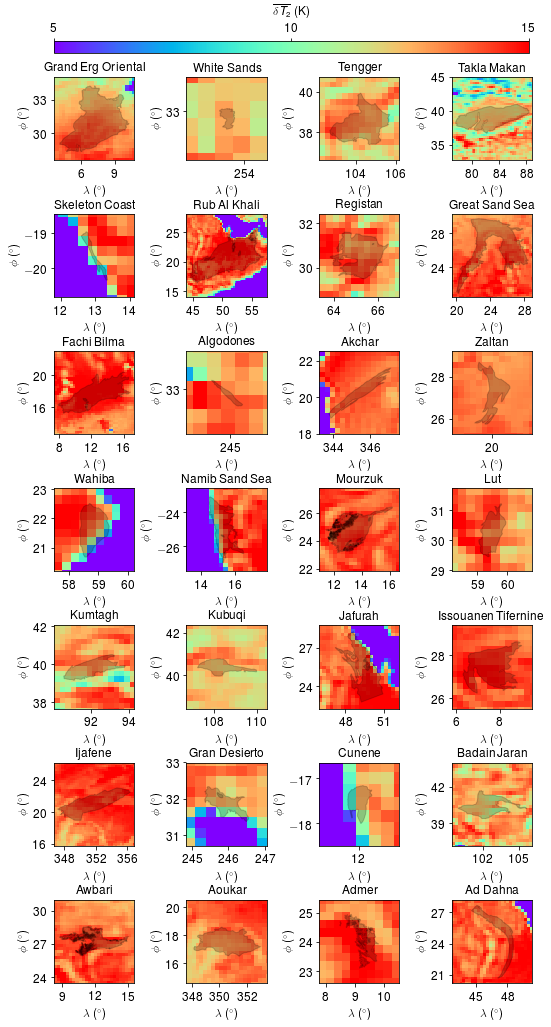

In [213]:
plt.rcParams['text.usetex'] = True #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = 'Helvetica' # Choose a nice font here

S = 90
LW = 0.8
fs = 12
SC = 100
v1 = 280
v2 = 300
v3 = 5
v4 = 15
v5 = -90
v6 = 90

%cd /media/synology2/WANDS/DUNEPOLY

lpu1 = 0
hpu1 = 25

lonbuff = np.max(np.diff(lonBL))+3.5
latbuff = -np.max(np.diff(latBL))+3.5

fig = plt.gcf()

for duneno in np.arange(0,np.shape(dunefields)[0]):
    
    ax2 = plt.subplot(7,4,duneno+1)

    with open(dunefields[duneno] + '_verts.pkl', 'rb') as f:
        vertups = pickle.load(f)
    vertups_lonpos = np.copy(vertups)
    patches = []    
    for i in np.arange(0,np.shape(vertups)[0]):
        temp = vertups_lonpos[i]
        temp[temp[:,0]<0,0] = temp[temp[:,0]<0,0] + 360
        patches.append(Polygon(temp, True))

    dunepatch2 = PatchCollection(patches, alpha=0.2,color='k')
    
    LATBLi,LONBLi = np.meshgrid(latBL[(latBL>boxtups[duneno,0,1]-latbuff)&(latBL<boxtups[duneno,2,1]+latbuff)],
                                lonBL[(lonBL>boxtups[duneno,0,0]-lonbuff)&(lonBL<boxtups[duneno,2,0]+lonbuff)])
    DDTAV_timei = np.reshape(DDTAV_time.T[(LONBL>boxtups[duneno,0,0]-lonbuff)&(LONBL<boxtups[duneno,2,0]+lonbuff)&
                                          (LATBL>boxtups[duneno,0,1]-latbuff)&(LATBL<boxtups[duneno,2,1]+latbuff)],
                             [np.shape(LATBLi)[0],np.shape(LATBLi)[1]])

    sc1 = ax2.pcolormesh(LONBLi, LATBLi, DDTAV_timei, cmap='rainbow',zorder=-1,vmin=v3,vmax=v4,rasterized=True)
    
    sc2 = ax2.add_collection(dunepatch2)

    ax2.set_xlabel('$\\lambda$ ($^{\\circ}$)', fontsize=fs)
    ax2.set_ylabel('$\\phi$ ($^{\\circ}$)', fontsize=fs)
    ax2.set_title(dunenames[duneno], loc='center', fontsize=fs)

    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)
    
    plt.axis('equal')
    
    plt.ylim([boxtups[duneno,0,1],boxtups[duneno,2,1]])
    plt.xlim([boxtups[duneno,0,0],boxtups[duneno,2,0]])

    ax2.xaxis.set_major_locator(MaxNLocator(nbins=3,min_n_ticks=1,integer=True))
    ax2.yaxis.set_major_locator(MaxNLocator(nbins=3,min_n_ticks=1,integer=True))

cbar2_ax = fig.add_axes([0.125, 0.90, 0.77, 0.01])
cbar2 = fig.colorbar(sc1, ticks=[5,10,15], cax=cbar2_ax, orientation='horizontal')
cbar2.ax.set_xticklabels(['5','10','15'])
cbar2.ax.xaxis.set_ticks_position('top')
cbar2.set_label('$\\overline{\\delta T_2}$ (K)',fontsize=fs)
cbar2.ax.xaxis.set_label_position('top')
cbar2.ax.tick_params(labelsize=fs)

fig.subplots_adjust(wspace=0.65)
fig.subplots_adjust(hspace=0.65)

x = 15
fig.set_size_inches(x*4/7, x*1/0.9, forward=True)
%cd /home/andrew/Documents/
plt.savefig('some_name84.png', bbox_inches='tight',dpi=300)
plt.savefig('some_name84.pdf', bbox_inches='tight',dpi=300)

/media/synology2/WANDS/DUNEPOLY
/home/andrew/Documents


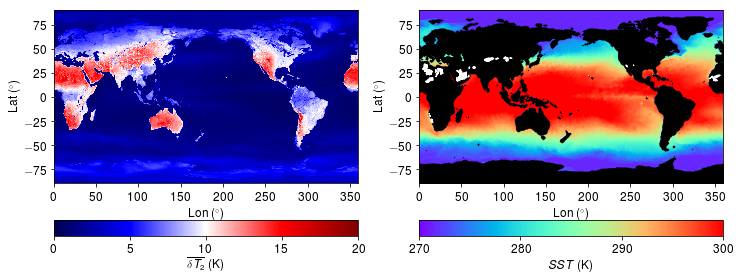

In [137]:
plt.rcParams['text.usetex'] = True #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = 'Helvetica' # Choose a nice font here

S = 0.1
LW = 0.8
fs = 12
SC = 100

v1 = 0
v2 = 20
v3 = 270
v4 = 300

lpu1 = 0
hpu1 = 25

%cd /media/synology2/WANDS/DUNEPOLY

patches = []

for i in np.arange(0,np.shape(dunefields)[0]):
    with open(dunefields[i] + '.pkl', 'rb') as f:
        vertups = pickle.load(f)
    vertups_lonpos = np.copy(vertups)
    vertups_lonpos[vertups_lonpos[:,0]<0,0] = vertups_lonpos[vertups_lonpos[:,0]<0,0] + 360
    patches.append(Polygon(vertups_lonpos, True))

fig = plt.gcf()

ax2 = plt.subplot(221)

sc1 = ax2.pcolormesh(LON, LAT, DDTAV_time.T, cmap='seismic',zorder=-1,vmin=v1,vmax=v2)

ax2.set_xlabel('Lon ($^{\\circ}$)', fontsize=fs)
ax2.set_ylabel('Lat ($^{\\circ}$)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

cbar2 = fig.colorbar(sc1, ticks=[0,5,10,15,20], ax=ax2, orientation='horizontal')
cbar2.ax.set_xticklabels(['0','5','10','15','20'])
cbar2.ax.xaxis.set_ticks_position('bottom')
cbar2.set_label('$\\overline{\\delta T_2}$ (K)',fontsize=fs)
cbar2.ax.xaxis.set_label_position('bottom')
cbar2.ax.tick_params(labelsize=fs)

ax2 = plt.subplot(222)

dunepatches = PatchCollection(patches, alpha=1,color='w')
    
sc1 = ax2.scatter(LON[SST.T==273.1604], LAT[SST.T==273.1604], c='k',s=S)
sc1 = ax2.pcolormesh(LON, LAT, SST.T, cmap='rainbow',zorder=-1,vmin=v3,vmax=v4)
sc4 = ax2.add_collection(dunepatches)

ax2.set_xlabel('Lon ($^{\\circ}$)', fontsize=fs)
ax2.set_ylabel('Lat ($^{\\circ}$)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)

plt.ylim([-90,90])
plt.xlim([0,360])

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

cbar2 = fig.colorbar(sc1, ticks=[270,280,290,300], ax=ax2, orientation='horizontal')
cbar2.ax.set_xticklabels(['270','280','290','300'])
cbar2.ax.xaxis.set_ticks_position('bottom')
cbar2.set_label('$SST$ (K)',fontsize=fs)
cbar2.ax.xaxis.set_label_position('bottom')
cbar2.ax.tick_params(labelsize=fs)


fig.set_size_inches(12, 10, forward=True)
%cd /home/andrew/Documents/
# plt.savefig('some_name79.png', bbox_inches='tight',dpi=300)

In [208]:
##################
# MAKE HISTOGRAMS BINS AND MEAN RELATIONSHIPS FOR EACH DUNEFIELD'S DDT TIME USM
##################

USMav_spaces = np.empty(np.shape(USM_spaces)[0])
duddT = np.empty(np.shape(USM_spaces)[0])

xxx3l = 0
xxx3h = 40
yyy1l = 0
yyy1h = 40
yyy2l = 0
yyy2h = 365

# n = 40
# minratioformean_yy1xx3 = 7000
# criticalddt = 0.4*1500**2/(60*60*24)/0.3/2

# n_options = np.arange(20,60+5,5)
# minratioformean_yy1xx3_options = np.arange(5000,10000+1000,1000)
# criticalddt_options = np.arange(15,19+0.5,0.5)

n_options = [35]
minratioformean_yy1xx3_options = [10000]

rh = 1.2
cp = 1004
Fh = 550/cp/rh
td = 24*60*60
A  = 0.2
H  = 1000
Ga = -0.0098
criticalddt_options = [(1+A)*td*Fh/H/np.pi - Ga*H/np.pi]

dune_data_points = 0

for k in n_options:
    
    xxx3bins = np.linspace(xxx3l, xxx3h, k)
    yyy1bins = np.linspace(yyy1l, yyy1h, k)
    yyy2bins = np.linspace(yyy2l, yyy2h, k)

    xxx3av_xxx3bins = (xxx3bins[:-1] + xxx3bins[1:])/2
    yyy2av_yyy2bins = (yyy2bins[:-1] + yyy2bins[1:])/2

    yyy2s = []
    xxx3s = []
    yyy1s = []

    yyy1av_xxx3bins = np.empty([np.shape(xxx3av_xxx3bins)[0],np.shape(dunefields)[0]])
    yyy1av_yyy2bins = np.empty([np.shape(xxx3av_xxx3bins)[0],np.shape(dunefields)[0]])
    xxx3av_yyy2bins = np.empty([np.shape(xxx3av_xxx3bins)[0],np.shape(dunefields)[0]])

    for l in minratioformean_yy1xx3_options:
    
        for m in criticalddt_options:
        
            criticalddt_index = np.argmin(np.abs(xxx3av_xxx3bins-m))
            
            for i in np.arange(0,np.shape(dunefields)[0]):
            
                duneDDT_flat = np.ndarray.flatten(DDT_spaces[i])
                duneUSM_flat = np.ndarray.flatten(USM_spaces[i])
                
                dune_data_points = dune_data_points + np.shape(duneDDT_flat)[0]
                
                mincountformean_yy1xx3 = np.shape(duneDDT_flat)[0]/l

                USMav_spaces[i] = np.mean(USM_spaces[i])

                time = np.arange(0,np.shape(DDT_spaces[i])[1])
                TIME = np.tile(time,(np.shape(DDT_spaces[i])[0],1))
                TIME_flat = np.ndarray.flatten(TIME)

                yyy2 = TIME_flat%365
                xxx3 = duneDDT_flat
                yyy1 = duneUSM_flat

                yyy1av_xxx3bin = np.empty(np.shape(xxx3av_xxx3bins)[0])
                yyy1av_xxx3bin[:] = np.nan

                for j in np.arange(0,np.shape(yyy1av_xxx3bin)[0]):

                    if np.shape(yyy1[(xxx3>=xxx3bins[j])&(xxx3<=xxx3bins[j+1])])[0]>mincountformean_yy1xx3:
                        yyy1av_xxx3bin[j] = np.mean(yyy1[(xxx3>=xxx3bins[j])&(xxx3<=xxx3bins[j+1])])

                yyy1av_yyy2bin = np.empty(np.shape(yyy2av_yyy2bins)[0])
                yyy1av_yyy2bin[:] = np.nan

                for j in np.arange(0,np.shape(yyy1av_yyy2bin)[0]):
                    yyy1av_yyy2bin[j] = np.mean(yyy1[(yyy2>=yyy2bins[j])&(yyy2<=yyy2bins[j+1])])

                xxx3av_yyy2bin = np.empty(np.shape(yyy2av_yyy2bins)[0])
                xxx3av_yyy2bin[:] = np.nan

                for j in np.arange(0,np.shape(xxx3av_yyy2bin)[0]):
                    xxx3av_yyy2bin[j] = np.mean(xxx3[(yyy2>=yyy2bins[j])&(yyy2<=yyy2bins[j+1])])

                yyy1av_xxx3bins[:,i] = yyy1av_xxx3bin
                yyy1av_yyy2bins[:,i] = yyy1av_yyy2bin
                xxx3av_yyy2bins[:,i] = xxx3av_yyy2bin

                yyy2s.append(yyy2)
                xxx3s.append(xxx3)
                yyy1s.append(yyy1)

                tempy = np.copy(yyy1av_xxx3bins[criticalddt_index:,i])
                tempyy = tempy[~np.isnan(tempy)]
                tempx = xxx3av_xxx3bins[criticalddt_index:]
                tempxx = tempx[~np.isnan(tempy)]
                
                try:
                    linreg = np.polyfit(tempxx, tempyy,deg=1)
                    duddT[i] = linreg[0]
                except:
                    continue
                    
            duneXX = [np.log10(duneareas**0.5/USMav_spaces),duddT]

            duneXXcov = np.corrcoef(duneXX)
            duneXXcov = duneXXcov[0,1]

            print(k,l,m,duneXXcov)


35 10000 18.18525938604909 0.35641170693811114


In [201]:
##################
# MAKE EQUIVALENT HISTOGRAMS BINS AND MEAN RELATIONSHIPS FOR GLOBAL LAND
##################


n = 40

xxx1l = 0
xxx1h = 40
xxx2l = 0
xxx2h = 40

land_data_points = 0

COUNT_land = np.empty([LANDSPLIT,n-1,n-1])
XXX2av_XXX1bins = np.empty([LANDSPLIT,n-1])

%cd /media/synology2/WANDS/DUNEPOLY

for i in np.arange(0,LANDSPLIT):
    with open(str(i)+'_land_USM.pkl', 'rb') as f:
            USM_land = pickle.load(f)
            
    with open(str(i)+'_land_DDT.pkl', 'rb') as f:
            DDT_land = pickle.load(f)   
            
    landDDT_flat = np.ndarray.flatten(DDT_land)
    landUSM_flat = np.ndarray.flatten(USM_land)
    
    land_data_points = land_data_points + np.shape(landDDT_flat)[0]

    xxx1 = landDDT_flat
    xxx2 = landUSM_flat

    xxx1bins = np.linspace(xxx1l, xxx1h, n)
    xxx2bins = np.linspace(xxx2l, xxx2h, n)

    counts, _, _ = np.histogram2d(xxx1, xxx2, bins=(xxx1bins, xxx2bins))

    xxx1av_xxx1bins = (xxx1bins[:-1] + xxx1bins[1:])/2

    xxx2av_xxx1bins = np.empty(np.shape(xxx1av_xxx1bins)[0])
    for j in np.arange(0,np.shape(xxx2av_xxx1bins)[0]):
        xxx2av_xxx1bins[j] = np.mean(xxx2[(xxx1>=xxx1bins[j])&(xxx1<=xxx1bins[j+1])])
        
    COUNT_land[i,:,:] = counts
    XXX2av_XXX1bins[i,:] = xxx2av_xxx1bins
    
    print(i)
    
count_land = np.sum(COUNT_land,axis=0)
Xxx2av_Xxx1bins = np.nanmean(XXX2av_XXX1bins,axis=0)
Xxx1av_Xxx1bins = xxx1av_xxx1bins

/media/synology2/WANDS/DUNEPOLY
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63


In [218]:
(dune_data_points/land_data_points)*100

1.2245032917940277

In [203]:

for i in np.arange(0,np.shape(dunefields)[0]):
    duneno = i
    
    plt.rcParams['text.usetex'] = True #Let TeX do the typsetting
    plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)
    plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
    plt.rcParams['font.sans-serif'] = 'Helvetica' # Choose a nice font here

    
    S = 90
    LW = 2
    fs = 12
    SC = 100
    LC1 = 'c'
    LC2 = 'm'

    v1 = 0
    v2 = 4
    v3 = 0
    v4 = 6

    lpu1 = 0
    hpu1 = 25

    fig = plt.gcf()

    ax2 = plt.subplot(221)

    counts, _, _ = np.histogram2d(xxx3s[duneno], yyy1s[duneno], bins=(xxx3bins, yyy1bins))

    sc1 = ax2.pcolormesh(xxx3bins, yyy1bins, np.log10(counts).T,cmap='magma_r',vmin=v1,vmax=v2,zorder=-1)
    s =   ax2.plot(xxx3av_xxx3bins, yyy1av_xxx3bins[:,duneno],lw=LW,c=LC1,label='average ' + dunenames[duneno])

    plt.ylim([yyy1l,yyy1h])
    plt.xlim([xxx3l,xxx3h])

    ax2.set_xlabel('$\\delta T_{2}$ (K)', fontsize=fs)
    ax2.set_ylabel('$u_{10, max}$ (m/s)', fontsize=fs)
    ax2.set_title('', loc='left', fontsize=fs)

    l = ax2.legend(loc=1,frameon=False,fontsize=fs,handlelength=1)

    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)

    ax2.set_xticks([0,20,40])
    ax2.set_xticklabels(['0','20','40'],fontsize=fs)
    ax2.set_yticks([0,20,40])
    ax2.set_yticklabels(['0','20','40'],fontsize=fs)

    cbar2 = fig.colorbar(sc1, ticks=[0,2,4], ax=ax2, orientation='horizontal')
    cbar2.ax.set_xticklabels(['$10^0$','$10^2$','$10^4$'])
    cbar2.ax.xaxis.set_ticks_position('bottom')
    cbar2.set_label('$n$',fontsize=fs)
    cbar2.ax.xaxis.set_label_position('bottom')
    cbar2.ax.tick_params(labelsize=fs)

    ax2 = plt.subplot(222)

    counts, _, _ = np.histogram2d(yyy2s[duneno], yyy1s[duneno], bins=(yyy2bins, yyy1bins))

    sc1 = ax2.pcolormesh(yyy2bins, yyy1bins, np.log10(counts).T,cmap='magma_r',vmin=v1,vmax=v2,zorder=-1)
    s =   ax2.plot(yyy2av_yyy2bins, yyy1av_yyy2bins[:,duneno],lw=LW,c=LC1)

    plt.ylim([yyy1l,yyy1h])
    plt.xlim([yyy2l,yyy2h])

    ax2.set_ylabel('$u_{10, max}$ (m/s)', fontsize=fs)
    ax2.set_title('', loc='left', fontsize=fs)

    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)

    ax2.set_xticks(np.arange(0+15,365-15,365/12))
    ax2.set_xticklabels(['','','','','','','','','','','',''],fontsize=fs)
    ax2.set_yticks([0,20,40])
    ax2.set_yticklabels(['0','20','40'],fontsize=fs)

    ax2 = plt.subplot(223)

    sc1 = ax2.pcolormesh(xxx1bins, xxx2bins, np.log10(count_land).T,cmap='viridis_r',vmin=v3,vmax=v4,zorder=-1)
    s =   ax2.plot(Xxx1av_Xxx1bins, Xxx2av_Xxx1bins,lw=LW,c=LC2,label='average Global land')

    plt.ylim([xxx2l,xxx2h])
    plt.xlim([xxx1l,xxx1h])

    ax2.set_xlabel('$\\delta T_{2}$ (K)', fontsize=fs)
    ax2.set_ylabel('$u_{10, max}$ (m/s)', fontsize=fs)
    ax2.set_title('', loc='left', fontsize=fs)

    l = ax2.legend(loc=1,frameon=False,fontsize=fs,handlelength=1)

    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)

    ax2.set_xticks([0,20,40])
    ax2.set_xticklabels(['0','20','40'],fontsize=fs)
    ax2.set_yticks([0,20,40])
    ax2.set_yticklabels(['0','20','40'],fontsize=fs)

    cbar2 = fig.colorbar(sc1, ticks=[0,3,6], ax=ax2, orientation='horizontal')
    cbar2.ax.set_xticklabels(['$10^0$','$10^3$','$10^6$'])
    cbar2.ax.xaxis.set_ticks_position('bottom')
    cbar2.set_label('$n$',fontsize=fs)
    cbar2.ax.xaxis.set_label_position('bottom')
    cbar2.ax.tick_params(labelsize=fs)

    ax2 = plt.subplot(224)

    counts, _, _ = np.histogram2d(yyy2s[duneno], xxx3s[duneno], bins=(yyy2bins, xxx3bins))

    sc1 = ax2.pcolormesh(yyy2bins, xxx3bins, np.log10(counts).T,cmap='magma_r',vmin=v1,vmax=v2,zorder=-1)
    s =   ax2.plot(yyy2av_yyy2bins, xxx3av_yyy2bins[:,duneno],lw=LW,c=LC1)

    plt.ylim([xxx3l,xxx3h])
    plt.xlim([yyy2l,yyy2h])

    ax2.set_xlabel('$t$ (days)', fontsize=fs)
    ax2.set_ylabel('$\\delta T_{2}$ (K)', fontsize=fs)
    ax2.set_title('', loc='left', fontsize=fs)

    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)

    ax2.set_xticks(np.arange(0+15,365-15,365/12))
    ax2.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'],fontsize=fs)
    ax2.set_yticks([0,20,40])
    ax2.set_yticklabels(['0','20','40'],fontsize=fs)

    fig.subplots_adjust(hspace=0.1)

    fig.set_size_inches(12, 12, forward=True)
    %cd /home/andrew/Documents/
    plt.savefig(dunefields[duneno] + '_coav.png', bbox_inches='tight',dpi=300)
    plt.clf()

/home/andrew/Documents
/home/andrew/Documents
/home/andrew/Documents
/home/andrew/Documents
/home/andrew/Documents
/home/andrew/Documents
/home/andrew/Documents
/home/andrew/Documents
/home/andrew/Documents
/home/andrew/Documents
/home/andrew/Documents
/home/andrew/Documents
/home/andrew/Documents
/home/andrew/Documents
/home/andrew/Documents
/home/andrew/Documents
/home/andrew/Documents
/home/andrew/Documents
/home/andrew/Documents
/home/andrew/Documents
/home/andrew/Documents
/home/andrew/Documents
/home/andrew/Documents
/home/andrew/Documents
/home/andrew/Documents
/home/andrew/Documents
/home/andrew/Documents
/home/andrew/Documents


<Figure size 864x864 with 0 Axes>

In [ ]:
##################
# MAKE INTERQUARTILE RANGE LINES FOR DDT AND AREA PLOT FOR DUNEFIELDS
##################

DDTIQR_DDT = np.empty([np.shape(dunefields)[0],2])
DDTIQR_AREA = np.empty([np.shape(dunefields)[0],2])

for i in np.arange(0,np.shape(dunefields)[0]):
    DDTIQR_DDT[i,:] = [np.percentile(DDTav_spaces[i],25),np.percentile(DDTav_spaces[i],75)]
    DDTIQR_AREA[i,:] = [duneareas[i],duneareas[i]]

In [204]:
##################
# MAKE BOUNDS FOR ALL DUNE FIELD BOXES WITH BUFFER AROUND FOR FIGURES
##################

%cd /media/synology2/WANDS/DUNEPOLY/

LAT,LON = np.meshgrid(lat,lon)

fieldlat_extent = np.empty([np.shape(dunefields)[0],2])

#make bounds for image around dune field
for i in np.arange(0,np.shape(dunefields)[0]):

    with open(dunefields[i] + '.pkl', 'rb') as f:
        vertups = pickle.load(f)
    
    vertups_lonpos = np.copy(vertups)
    vertups_lonpos[vertups_lonpos[:,0]<0,0] = vertups_lonpos[vertups_lonpos[:,0]<0,0] + 360
    
    fieldlat_extent[i,0] = np.min(vertups_lonpos[:,1])
    fieldlat_extent[i,1] = np.max(vertups_lonpos[:,1])
    
fieldlat_x = np.asarray([np.arange(0,np.shape(fieldlat_extent)[0]),np.arange(0,np.shape(fieldlat_extent)[0])]).T

fieldlat_y = fieldlat_extent[np.argsort(np.min(np.abs(fieldlat_extent),axis=1)),:]

fieldlat_n = []
for i in np.argsort(np.abs(fieldlat_extent[:,0])):
    fieldlat_n.append(dunenames[i])
    
fieldlat_a = duneareas[np.argsort(np.abs(fieldlat_extent[:,0]))]


/media/synology2/WANDS/DUNEPOLY


/home/andrew/Documents


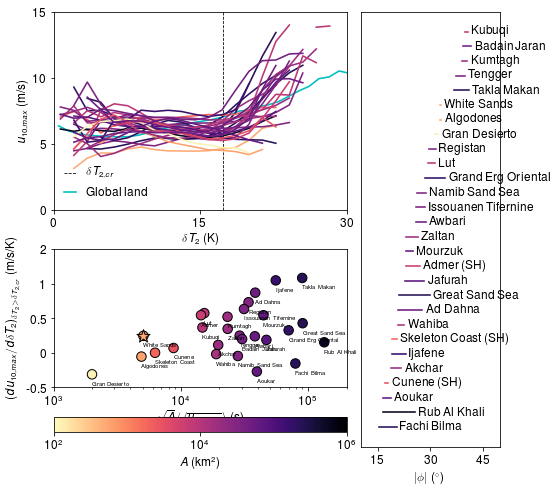

In [956]:
plt.rcParams['text.usetex'] = True #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = 'Helvetica' # Choose a nice font here

S = 90
LW = 0.8
LW2 = 1.6
fs = 12
SC = 100
v5 = 2
v6 = 6
A = 1

lpu1 = 0
hpu1 = 25

fig = plt.gcf()

ax2 = plt.subplot2grid((2,3),(0,0),colspan=2)

sc4 = ax2.plot([criticalddt,criticalddt],[xxx2l,20],'--',lw=LW,alpha=A,c='k',label='$\\delta T_{2,cr}$')

sc1 = ax2.plot(Xxx1av_Xxx1bins, Xxx2av_Xxx1bins,lw=LW2,c='c',label='Global land')

cmap = plt.cm.get_cmap('magma_r')
for i in np.arange(0,np.shape(dunefields)[0]):

    c1 = cmap((np.log10(duneareas[i])-2)/(6-2))

    sc2 = ax2.plot(xxx3av_xxx3bins, yyy1av_xxx3bins[:,i],lw=LW2,alpha=A,c=c1)
    
sc3 = ax2.scatter(-10,-10,s=S,c=-10,cmap=cmap,vmin=2,vmax=6)

l = ax2.legend(loc=3,frameon=False,fontsize=fs,handlelength=1)

plt.ylim([xxx2l,15])
plt.xlim([xxx1l,30])

ax2.set_xlabel('$\\delta T_{2}$ (K)', fontsize=fs)
ax2.set_ylabel('$u_{10, max}$ (m/s)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax2.set_xticks([0,15,30])
ax2.set_xticklabels(['0','15','30'],fontsize=fs)
ax2.set_yticks([0,5,10,15])
ax2.set_yticklabels(['0','5','10','15'],fontsize=fs)

ax3 = plt.subplot2grid((2,3),(1,0),colspan=2)

sc1 = ax3.scatter((duneareas*10**6)**0.5/USMav_spaces,duddT,s=S,c=np.log10(duneareas),cmap='magma_r',vmin=v5,vmax=v6,edgecolors='k')

sc2 = ax3.scatter((duneareas[1]*10**6)**0.5/USMav_spaces[1],duddT[1],s=S+100,c=np.log10(duneareas[1]),cmap='magma_r',vmin=v5,vmax=v6,edgecolors='k',marker="*")

for i in np.arange(0,np.shape(dunefields)[0]):
    plt.annotate(dunenames[i],((duneareas[i]*10**6)**0.5/USMav_spaces[i]+1,duddT[i]-0.2),fontsize=fs-6)

ax3.set_ylabel('$\\left(d u_{10,max}/d\\delta T_{2}\\right)_{\\delta T_{2}>\\delta T_{2,cr}}$ (m/s/K)', fontsize=fs)
ax3.set_xlabel('$\\sqrt{A}/\\left<\\overline{u_{10,max}}\\right>$ (s)', fontsize=fs)

ax3.set_xscale('log')

plt.xlim(10**3,2*10**5)
plt.ylim(-0.5,1.5)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.yticks(np.linspace(-0.5,2,5), ('-0.5', '0', '0.5', '1', '2'))

cbar2 = fig.colorbar(sc3, ticks=[2,4,6], ax=ax3, orientation='horizontal')
cbar2.ax.set_xticklabels(['$10^2$','$10^4$','$10^6$'])
cbar2.ax.xaxis.set_ticks_position('bottom')
cbar2.set_label('$A$ (km$^{2}$)',fontsize=fs)
cbar2.ax.xaxis.set_label_position('bottom')
cbar2.ax.tick_params(labelsize=fs)

ax2 = plt.subplot2grid((2,3),(0,2),rowspan=2)

cmap = plt.cm.get_cmap('magma_r')
for i in np.arange(0,np.shape(dunefields)[0]):

    c1 = cmap((np.log10(fieldlat_a[i])-2)/(6-2))
    
    if fieldlat_y[i,0]>0:
        sc2 = ax2.plot(fieldlat_y[i,:],fieldlat_x[i,:],lw=LW2,alpha=A,c=c1)
        plt.annotate(fieldlat_n[i],(fieldlat_y[i,1]+1,fieldlat_x[i,0]-0.2),fontsize=fs)

    else:
        sc2 = ax2.plot(-fieldlat_y[i,:],fieldlat_x[i,:],lw=LW2,alpha=A,c=c1)
        plt.annotate(fieldlat_n[i]+' (SH)',(-fieldlat_y[i,0]+1,fieldlat_x[i,0]-0.2),fontsize=fs)
        
ax2.set_xlabel('$|\\phi|$ ($^{\\circ}$)',fontsize=fs)

plt.xlim(10,50)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xticks([15,30,45], ('15', '30', '45'))
plt.yticks([], ())

fig.subplots_adjust(hspace=0.2)
fig.subplots_adjust(wspace=0.1)

fig.set_size_inches(8,8, forward=True)
%cd /home/andrew/Documents/
plt.savefig('some_name80.png', bbox_inches='tight',dpi=300)
# plt.savefig('some_name80.pdf', bbox_inches='tight')

/home/andrew/Documents


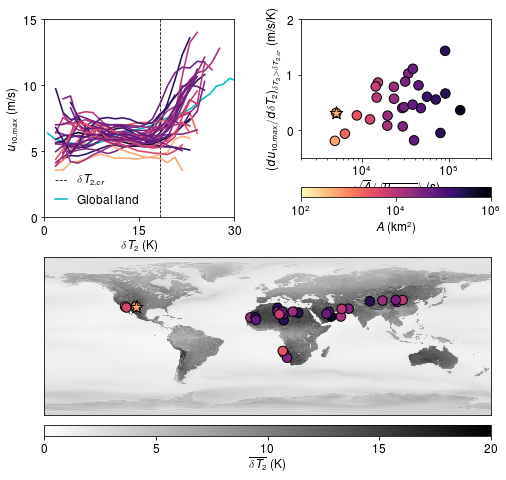

In [222]:
plt.rcParams['text.usetex'] = True #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = 'Helvetica' # Choose a nice font here

S = 90
LW = 0.8
LW2 = 1.6
fs = 12
SC = 100
v5 = 2
v6 = 6
A = 1
v1 = 0
v2 = 20

lpu1 = 0
hpu1 = 25

fig = plt.gcf()

ax2 = plt.subplot2grid((2,2),(0,0))

criticalddt = criticalddt_options[0]

sc4 = ax2.plot([criticalddt,criticalddt],[xxx2l,20],'--',lw=LW,alpha=A,c='k',label='$\\delta T_{2,cr}$')

sc1 = ax2.plot(Xxx1av_Xxx1bins, Xxx2av_Xxx1bins,lw=LW2,c='c',label='Global land')

cmap = plt.cm.get_cmap('magma_r')
for i in np.arange(0,np.shape(dunefields)[0]):

    c1 = cmap((np.log10(duneareas[i])-2)/(6-2))

    sc2 = ax2.plot(xxx3av_xxx3bins, yyy1av_xxx3bins[:,i],lw=LW2,alpha=A,c=c1)
    
sc3 = ax2.scatter(-10,-10,s=S,c=-10,cmap=cmap,vmin=2,vmax=6)

l = ax2.legend(loc=3,frameon=False,fontsize=fs,handlelength=1)

plt.ylim([xxx2l,15])
plt.xlim([xxx1l,30])

ax2.set_xlabel('$\\delta T_{2}$ (K)', fontsize=fs)
ax2.set_ylabel('$u_{10, max}$ (m/s)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax2.set_xticks([0,15,30])
ax2.set_xticklabels(['0','15','30'],fontsize=fs)
ax2.set_yticks([0,5,10,15])
ax2.set_yticklabels(['0','5','10','15'],fontsize=fs)

ax3 = plt.subplot2grid((2,2),(0,1))

sc1 = ax3.scatter((duneareas*10**6)**0.5/USMav_spaces,duddT,s=S,c=np.log10(duneareas),cmap='magma_r',vmin=v5,vmax=v6,edgecolors='k')

sc2 = ax3.scatter((duneareas[1]*10**6)**0.5/USMav_spaces[1],duddT[1],s=S*2,c=np.log10(duneareas[1]),cmap='magma_r',vmin=v5,vmax=v6,edgecolors='k',marker="*")

ax3.set_ylabel('$\\left(d u_{10,max}/d\\delta T_{2}\\right)_{\\delta T_{2}>\\delta T_{2,cr}}$ (m/s/K)', fontsize=fs)
ax3.set_xlabel('$\\sqrt{A}/\\left<\\overline{u_{10,max}}\\right>$ (s)', fontsize=fs)

ax3.set_xscale('log')

plt.xlim(2*10**3,3*10**5)
plt.ylim(-0.5,1.5)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.yticks(np.linspace(0,2,3), ('0', '1', '2'))

cbar2 = fig.colorbar(sc3, ticks=[2,4,6], ax=ax3, orientation='horizontal')
cbar2.ax.set_xticklabels(['$10^2$','$10^4$','$10^6$'])
cbar2.ax.xaxis.set_ticks_position('bottom')
cbar2.set_label('$A$ (km$^{2}$)',fontsize=fs)
cbar2.ax.xaxis.set_label_position('bottom')
cbar2.ax.tick_params(labelsize=fs)

ax4 = plt.subplot2grid((2,2),(1,0),colspan=2)

forddtmap = np.concatenate((DDTAV_time[:,640:],DDTAV_time[:,:640]),axis=1).T

# landbound = np.concatenate((SST[:,640:],SST[:,:640]),axis=1).T
# forddtmap[landbound!=273.1604] = np.nan

# sc1 = ax4.pcolormesh(LON-180, LAT, forddtmap, cmap='seismic',zorder=-1,vmin=v1,vmax=v2,rasterized=True,alpha=0.5)
sc1 = ax4.pcolormesh(LON-180, LAT, forddtmap, cmap='binary',zorder=-1,vmin=v1,vmax=v2,rasterized=True)

sc2 = ax4.scatter(duneavlons,duneavlats,s=S,c=np.log10(duneareas),cmap='magma_r',vmin=v5,vmax=v6,edgecolors='k')

sc2 = ax4.scatter(duneavlons[1],duneavlats[1],s=S*2,c=np.log10(duneareas[1]),cmap='magma_r',vmin=v5,vmax=v6,edgecolors='k',marker="*")

# ax4.set_xlabel('$\\lambda$ ($^{\\circ}$)', fontsize=fs)
# ax4.set_ylabel('$\\phi$ ($^{\\circ}$)', fontsize=fs)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

# plt.yticks(np.linspace(-90,90,5), ('-90', '-45', '0', '45', '90'))
# plt.xticks(np.linspace(-180,180,5), ('-180', '-90', '0', '90', '180'))

ax4.set_xlabel('', fontsize=fs)
ax4.set_ylabel('', fontsize=fs)
plt.yticks([], ())
plt.xticks([], ())

cbar2 = fig.colorbar(sc1, ticks=[0,5,10,15,20], ax=ax4, orientation='horizontal',aspect=40,pad=0.05)
cbar2.ax.set_xticklabels(['0','5','10','15','20'])
cbar2.ax.xaxis.set_ticks_position('bottom')
cbar2.set_label('$\\overline{\\delta T_2}$ (K)',fontsize=fs)
cbar2.ax.xaxis.set_label_position('bottom')
cbar2.ax.tick_params(labelsize=fs)

fig.subplots_adjust(hspace=0.2)
fig.subplots_adjust(wspace=0.35)

fig.set_size_inches(8,8, forward=True)
%cd /home/andrew/Documents/
plt.savefig('some_name85.png', bbox_inches='tight',dpi=300)
plt.savefig('some_name85.pdf', bbox_inches='tight',dpi=300)

In [2]:
rh = 1.2
cp = 1004
Fh = 550/cp/rh
td = 24*60*60
A  = 0.2
H  = 1000
Ga = -0.0098

(1+A)*td*Fh/H/np.pi - Ga*H/np.pi

18.18525938604909

In [3]:
(H*(np.pi*18+Ga*H)/(1+A)/td)*cp*rh

543.2368337462354

In [5]:
Ch = 0.01
Cd = Ch*1.2

us = 0.5
(Ch*us/Cd**0.5*9.9)*cp*rh

544.4143132578349

/home/andrew/Documents


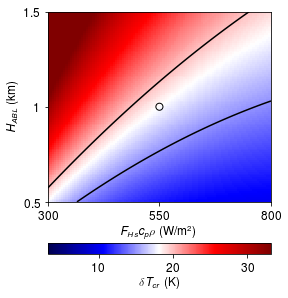

In [58]:
N = 100

F_min1 = 10/cp/rh
F_max1 = 1000/cp/rh
H_min1 = 10
H_max1 = 5000

f_x1 = np.logspace(np.log10(F_min1),np.log10(F_max1),N)
h_y1 = np.logspace(np.log10(H_min1),np.log10(H_max1),N)

F_x1,H_y1 = np.meshgrid(f_x1,h_y1)
dT_z1    = (1+A)*td*F_x1/H_y1/np.pi - Ga*H_y1/np.pi

F_min2 = 300/cp/rh
F_max2 = 800/cp/rh
H_min2 = 500
H_max2 = 1500

f_x2 = np.linspace(F_min2,F_max2,N)
h_y2 = np.linspace(H_min2,H_max2,N)

F_x2,H_y2 = np.meshgrid(f_x2,h_y2)
dT_z2    = (1+A)*td*F_x2/H_y2/np.pi - Ga*H_y2/np.pi

plt.rcParams['text.usetex'] = True #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = 'Helvetica' # Choose a nice font here

S = 50
LW = 0.8
fs = 12
SC = 100

v1 = 0
v2 = 20
v3 = 270
v4 = 300

lpu1 = 0
hpu1 = 25

fig = plt.gcf()

# ax2 = plt.subplot(121)

# sc1 = ax2.scatter(Fh*cp*rh, H, c='k',s=S)
# sc1 = ax2.pcolormesh(F_x1*cp*rh, H_y1, np.log10(dT_z1.T), cmap='magma_r',zorder=-1)
# sc2 = ax2.contour(F_x1*cp*rh, H_y1, np.log10(dT_z1.T), levels=[np.log10(15),np.log10(20)],colors='k')

# ax2.set_xlabel('$F_{Hs}c_{p}\\rho$ (W/m$^{2}$)', fontsize=fs)
# ax2.set_ylabel('$H_{ABL}$ (m)', fontsize=fs)

# ax2.set_xscale('log')
# ax2.set_yscale('log')

# plt.xlim([F_min1*cp*rh,F_max1*cp*rh])
# plt.ylim([H_min1,H_max1])

# plt.xticks(fontsize=fs)
# plt.yticks(fontsize=fs)

# cbar2 = fig.colorbar(sc1, ticks=[1,2,3], ax=ax2, orientation='horizontal')
# cbar2.ax.set_xticklabels(['10$^{1}$','10$^{2}$','10$^{3}$'])
# cbar2.ax.xaxis.set_ticks_position('bottom')
# cbar2.set_label('$\\delta T$ (K)',fontsize=fs)
# cbar2.ax.xaxis.set_label_position('bottom')
# cbar2.ax.tick_params(labelsize=fs)

# ax3 = plt.subplot(122)

ax3 = plt.subplot(111)

dT_z = (1+A)*td*Fh/H/np.pi - Ga*H/np.pi
dT_z_buff = 15
v1 = dT_z-dT_z_buff
v2 = dT_z+dT_z_buff

sc1 = ax3.scatter(Fh*cp*rh, H, c='none',s=S,edgecolor='k')
sc1 = ax3.pcolormesh(F_x2*cp*rh, H_y2, dT_z2.T, cmap='seismic',zorder=-1,vmin=v1,vmax=v2)
sc2 = ax3.contour(F_x2*cp*rh, H_y2, dT_z2.T, levels=[15,20],colors='k')

ax3.set_xlabel('$F_{Hs}c_{p}\\rho$ (W/m$^{2}$)', fontsize=fs)
ax3.set_ylabel('$H_{ABL}$ (km)', fontsize=fs)

plt.xticks([300,550,800], ('300', '550', '800'))
plt.yticks([500,1000,1500], ('0.5', '1', '1.5'))

plt.xlim([F_min2*cp*rh,F_max2*cp*rh])
plt.ylim([H_min2,H_max2])

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

cbar3 = fig.colorbar(sc1,ticks=[10,20,30], ax=ax3, orientation='horizontal')
cbar3.ax.xaxis.set_ticks_position('bottom')
cbar3.set_label('$\\delta T_{cr}$ (K)',fontsize=fs)
cbar3.ax.set_xticklabels(['10','20','30'])
cbar3.ax.xaxis.set_label_position('bottom')
cbar3.ax.tick_params(labelsize=fs)

fig.subplots_adjust(hspace=0.2)
fig.subplots_adjust(wspace=0.35)

fig.set_size_inches(4, 5, forward=True)
%cd /home/andrew/Documents/
plt.savefig('some_name86.png', bbox_inches='tight',dpi=300)
plt.savefig('some_name86.pdf', bbox_inches='tight')